# Local registration with ICP

    In the RGBD folder we have the first 400 images from one of the datasets from: (http://redwood-data.org/indoor_lidar_rgbd/download.html)


    If you want to display directly in jupyter notebook replace the **draw_registrations** with this:

```python
from open3d import JVisualizer

def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        visualizer = JVisualizer()
        visualizer.add_geometry(source_temp)
        visualizer.add_geometry(target_temp)
        visualizer.show()
```

In [4]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import copy
        
# Helper function to draw registrations (reccomended)
def draw_registrations(source, target, transformation = None, recolor = False):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        if(recolor):
            source_temp.paint_uniform_color([1, 0.706, 0])
            target_temp.paint_uniform_color([0, 0.651, 0.929])
        if(transformation is not None):
            source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

## Creating pointclouds from image data
Now we are going to try to create our own pointclouds from rgb and depth images.

In [25]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw1 = o3d.io.read_image("RGBD/color/000005.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000005.png")

Create pointclouds from rgb + depth images.

If you set *convert_rgb_to_intensity = False* you will retain the colors from the rgb image.

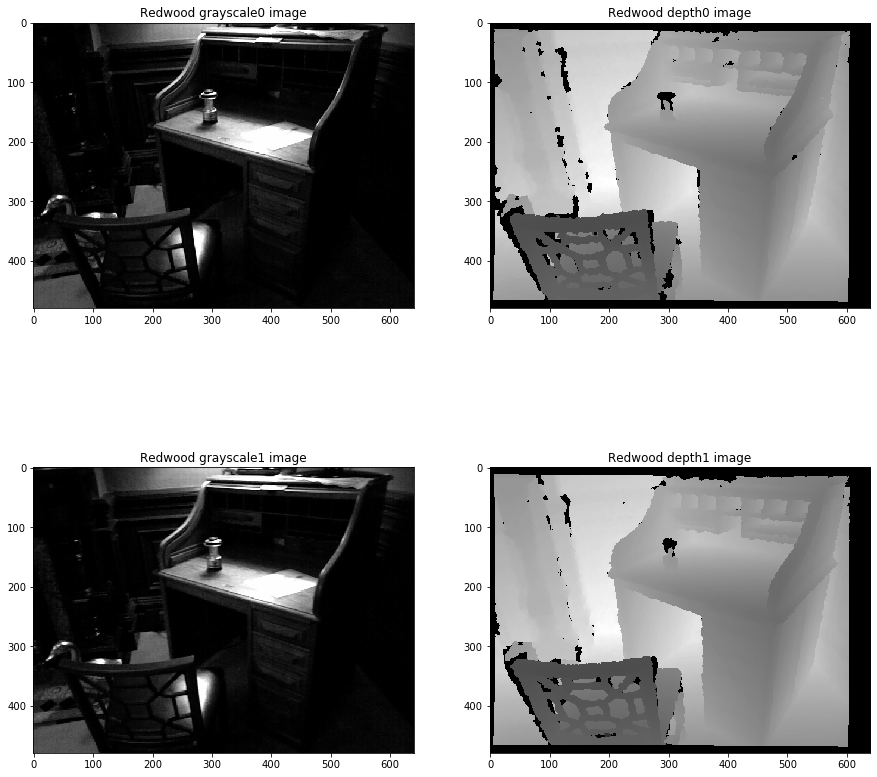

In [26]:
rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

#show images
fig= plt.figure(figsize=(15,15))
plt.subplot(221)
plt.title('Redwood grayscale0 image')
plt.imshow(rgbd_image0.color, cmap='gray')

plt.subplot(222)
plt.title('Redwood depth0 image')
plt.imshow(rgbd_image0.depth, cmap='gray')

plt.subplot(223)
plt.title('Redwood grayscale1 image')
plt.imshow(rgbd_image1.color, cmap='gray')

plt.subplot(224)
plt.title('Redwood depth1 image')
plt.imshow(rgbd_image1.depth, cmap='gray')

plt.show()


## Images to Pointcloud
Now we create point clouds from the rgbd images we just created.


Here we use **PinholeCameraIntrinsicParameters.PrimeSenseDefault** as default camera parameter. 

It has image resolution 640x480, focal length (fx, fy) = (525.0, 525.0), and optical center (cx, cy) = (319.5, 239.5). 

An identity matrix is used as the default extrinsic parameter. pcd.transform applies an up-down flip transformation on the point cloud for better visualization purpose.


If it becomes too slow you can downsample the pointcloud.

In [27]:
# Source pointcloud
camera = o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)

### Evaluation of pointclouds

Before we can run ICP we evaluate our source and target pointclouds. This gives us a measure to see if we need a better initial transformation or not.

[The function evaluate_registration calculates two main metrics. fitness measures the overlapping area (# of inlier correspondences / # of points in target). Higher the better. inlier_rmse measures the RMSE of all inlier correspondences. Lower the better.](http://www.open3d.org/docs/latest/tutorial/Basic/icp_registration.html)

In [9]:
# Parameters
threshold = 0.02
trans_init = np.asarray([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

#Evaluate registration
print("Initial alignment")
evaluation = o3d.pipelines.registration.evaluate_registration(source, target, threshold, trans_init)
print(evaluation)

Initial alignment
RegistrationResult with fitness=9.176427e-01, inlier_rmse=9.789196e-03, and correspondence_set size of 240059
Access transformation to get result.


## ICP

Now try to call icp with your point clouds and your initial transformation.

Initially we use:
```Python
point_to_plane =  o3d.registration.TransformationEstimationPointToPlane()

icp_result = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)

```

In [21]:
###
# ICP code here
###

#icp_result = o3d.registration.registration_icp()
#draw_registrations(source, target, icp_result.transformation, True)
#draw_registrations(source, target, icp_result.transformation)

def preprocess_point_cloud(pcd, voxel_size):
    #print(":: Downsample with a voxel size %.3f." % voxel_size)
    pcd_down = pcd#.voxel_down_sample(voxel_size)

    radius_normal = voxel_size #* 2
    print(":: Estimate normal with search radius %.3f." % radius_normal)
    pcd_down.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

    return pcd_down

def refine_registration(source, target, voxel_size, result_ransac):
    distance_threshold = voxel_size #* 0.4
    print(":: Point-to-plane ICP registration is applied on original point")
    print("   clouds to refine the alignment. This time we use a strict")
    print("   distance threshold %.3f." % distance_threshold)
    result = o3d.pipelines.registration.registration_icp(
        source, target, distance_threshold, result_ransac,
        o3d.pipelines.registration.TransformationEstimationPointToPlane())
    return result

In [22]:
source_sample = preprocess_point_cloud(source, threshold)
target_sample = preprocess_point_cloud(target, threshold)

icp_result = refine_registration(source, target, threshold, trans_init)

draw_registrations(source, target, icp_result.transformation, True)
draw_registrations(source, target, icp_result.transformation)

:: Estimate normal with search radius 0.020.
:: Estimate normal with search radius 0.020.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.


# Exersices

### A)
If you increase the amount of steps from the original image so from i.e. 000000-000001 to 00000-000300 what happens?
### B)
Can you tweak the parameters *threshold* and *trans_init* to combat some of the ill effects that starts appearing?
### C)
Again try to use 
```Python
point_to_plane =  o3d.registration.TransformationEstimationPointToPlane()

reg_p2p = o3d.registration.registration_icp(
    source, target, threshold, trans_init,
    point_to_plane)
```

This requires you to find the normals for each point cloud use:
```python
    source.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=0.5,
                            max_nn=30),fast_normal_computation=True)
```
Compare the resulting translations of the two methods is one better than the other?
### D)
Extend this and try to see how much of the bedroom you can reconstruct from the rgb and depth images.
you can extend a pointcloud by new = source + target remember to resample the point cloud some times so it does not get too large down_source = source.voxel_down_sample(voxel_size=0.05)

### A)

In [30]:
# Read in images. We have images 000000 - 0000400
color_raw0 = o3d.io.read_image("RGBD/color/000000.jpg")
depth_raw0 = o3d.io.read_image("RGBD/depth/000000.png")

color_raw1 = o3d.io.read_image("RGBD/color/000300.jpg")
depth_raw1 = o3d.io.read_image("RGBD/depth/000300.png")

rgbd_image0 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw0, 
    depth_raw0, 
    convert_rgb_to_intensity = True)

rgbd_image1 = o3d.geometry.RGBDImage.create_from_color_and_depth(
    color_raw1, 
    depth_raw1, 
    convert_rgb_to_intensity = True)

source = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image0, camera)

# Target pointcloud
target = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image1, camera)

# Flip it, otherwise the pointcloud will be upside down
source.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
target.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

# Draw
draw_registrations(source, target, recolor=True)

source_sample = preprocess_point_cloud(source, threshold)
target_sample = preprocess_point_cloud(target, threshold)

icp_result = refine_registration(source, target, threshold, trans_init)

draw_registrations(source, target, icp_result.transformation, True)
draw_registrations(source, target, icp_result.transformation)

:: Estimate normal with search radius 0.020.
:: Estimate normal with search radius 0.020.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.020.


### B)